In [2]:
# WARNING: IT IS IMPORTANT TO USE PYTHON 3.8
# THE CODE DOES NOT WORK WITH MORE RECENT VERSIONS
from utils.multimode_reservoir import MultiModeReservoir
from utils.information_processing_capacity import compute_ipc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Multimode Reservoir Class

We can create a multimode reservoir by calling the MultiModeReservoir class:

In [3]:
# MultiModeReservoir Class
# Parameters:
### N: number of pump frexel modes
### n: number of reservoir frexel modes
### input_enc: encoding type, can be 'phase' for phase encoding
###### or 'amplitude' for amplitude encoding (default = 'phase')
### delta_amp: scale of the phase encoding (default = 1e-18); ignore if using amplitude encoding
### seed: random seed (default = 42)

N,n = 5,5

res = MultiModeReservoir(N,n)

Some random parameters are computed inmediately when generating the reservoir, such as the encoding parameters or the mask matrix:

If we are using the phase encoding, the phase of the reservoir is given by

$ \theta_{i}(u) = \alpha_{i} u + \beta_{i} + \sum_{j=1}^{N} M_{ij} O_{j} $

where $i$ denotes the pump mode ($i = 1, \dots, N$). $\alpha$ and $\beta$ are encoding parameters and $M$ is the mask matrix for the feedback term (the $O_{j}$ are the feedback observables)

We can access the encoding parameters such as $\alpha$ and $\beta$:

In [4]:
print('alpha:',res.alpha)
print('beta:',res.beta)

alpha: [-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272]
beta: [-0.68801096 -0.88383278  0.73235229  0.20223002  0.41614516]


If we don't like those values, we can generate new random ones with the redo_alpha_beta function:

In [5]:
res.redo_alpha_beta()
print('new alpha:',res.alpha)
print('new beta:',res.beta)

new alpha: [ 0.6167947  -0.39077246 -0.80465577  0.36846605 -0.11969501]
new beta: [-0.75592353 -0.00964618 -0.93122296  0.8186408  -0.48244004]


We can also check the mask:

In [6]:
# mask_scale: scalar factor multiplied to the normalized mask matrix 
# (it control the fading memory in case the default value is not enough)

print('mask matrix:',res.mask())

mask matrix: [[0.00937842 0.44189675 0.37926587 0.09674297 0.08284055]
 [0.0835602  0.13861459 0.23908218 0.19679674 0.13268575]
 [0.27876385 0.06355424 0.13310286 0.16691666 0.20778822]
 [0.35773088 0.09097257 0.2342883  0.26990764 0.02116309]
 [0.27680108 0.07769181 0.0296379  0.43231795 0.43994775]]


which we can also re-compute if the previous one is not working properly:

In [7]:
res.redo_mask()
print('new mask matrix:',res.mask())

new mask matrix: [[0.24032089 0.11306892 0.18864755 0.19831167 0.06705342]
 [0.35170355 0.28116882 0.34079038 0.32458637 0.21688003]
 [0.33439725 0.03209944 0.0710901  0.01640558 0.11800912]
 [0.14098736 0.09842815 0.30061318 0.12940738 0.10190515]
 [0.19685557 0.05111833 0.29098597 0.02704223 0.35797972]]


## Utilities:

Printing the modes for a given scalar input $u$

/home/jorgegarcia/miniconda3/envs/old_py/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


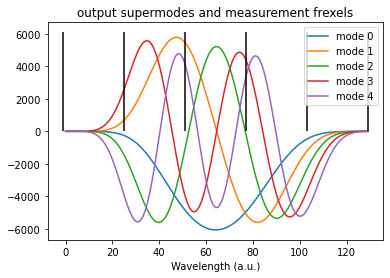

In [8]:
u = 0. #scalar input
res.plot_modes(u)

Checking the fading memory property:

Washing out initial conditions...


Computing reservoir states:   0%|          | 0/10 [00:00<?, ?it/s]/home/jorgegarcia/Desktop/env_jorge/experimental_setups/multimode_reservoir/utils/utils_functions.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  expanded_matrix[2 * i:2 * i + 2, 2 * j:2 * j + 2] = np.diag([U[i, j], U[i, j]])
Computing reservoir states: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Initial conditions washed out.
Injecting static input...


Computing reservoir states: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


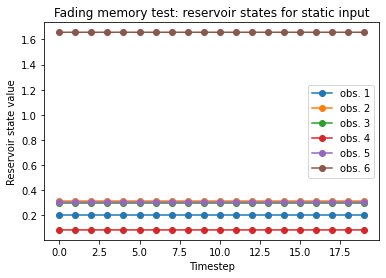

In [9]:
static_input = 0.5
res.test_fading_memory(static_input)

We can compute the reservoir state evolution for a given input sequence $\vec{u}$

In [10]:
u_vec = 2*np.random.random(100)-1

X,feedback = res.get_reservoir_sequence(u_vec)

Computing reservoir states: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


$X$ are the stored reservoir observables and has dimensions = (length of input sequence, # observables)

The feedback vector stores the last measured observables to be used in a possible future sequence.

In [11]:
print('X shape:',X.shape)
print('feedback vector length:',len(feedback))

X shape: (100, 15)
feedback vector length: 5


To use the feedback term for a new input sequence we use the 'feedback_0' parameter:

In [12]:
u_new = 2*np.random.random(5)-1.
X_new,_ = res.get_reservoir_sequence(u_new,feedback_0=feedback)

Computing reservoir states: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


And thus the new reservoir evolution will have memory from the previous sequence.

# Information Processing Capacity

The Informaton Processing Capacity (IPC) is a measured of overall performance and scaling of a reservoir. It is computed by feeding the reservoir a random sequence of inputs, computing the capacity over a complete and orthogonal family of functions and adding all of them.

Dambre, J., et al. Information Processing Capacity of Dynamical Systems. Sci Rep 2, 514 (2012). https://doi.org/10.1038/srep00514

In our case, the input is uniformly distributed between $u \in [-1, 1]$ and the family of functions are the normalized Legendre polynomials.

The following is a sample of code that computed the IPC for an already saved sequence and reservoir observables:

In [6]:
N,n = 5,5 # Number of modes in pump and signal
T = 1000 # length of the training step
Two = 100 # length of the wash out step

#list of degree-max_delay tuples that are taken into account in the computation
# each tuple corresponds to [degree, maximum delay] so the code computes the capacity for
# all the polynomials functions of that degree and delays up to maximum delay
# e.g. [3,10] means that the code will compute the capacity for all cubic polynomials
# including products of lower degree polynomial (e.g. P2*P1 and P1*P1*P1)
# with delays from 1 to 10 time steps for every polynomial
degdelay = [[1,20],[2,10],[3,10],[4,10],[5,5],[6,5],[7,5],[8,5],[9,5]]

# We load the input sequence (zeta) and the reservoir observables (X)
# they have been computed and stored previously using np.save
zeta = np.load('zeta_%i.npy' %(Two+T))
X = np.load('X_%i_%i.npy' %(N,n))

IPC = compute_ipc(X,zeta,Two,degdelay)

--- Degree 1 ---


100%|██████████| 21/21 [00:00<00:00, 422.99it/s]


threshold = 0.2
*** IPC = 1.80 ***
--- Degree 2 ---


100%|██████████| 66/66 [00:00<00:00, 691.19it/s]


threshold = 0.07677610630942702
*** IPC = 2.79 ***
--- Degree 3 ---


100%|██████████| 286/286 [00:00<00:00, 729.41it/s]


threshold = 0.07015508578637575
*** IPC = 2.89 ***
--- Degree 4 ---


100%|██████████| 1001/1001 [00:01<00:00, 786.15it/s]


threshold = 0.07326496586521555
*** IPC = 3.21 ***
--- Degree 5 ---


100%|██████████| 252/252 [00:00<00:00, 856.83it/s]


threshold = 0.07919176224345316
*** IPC = 2.29 ***
--- Degree 6 ---


100%|██████████| 461/461 [00:00<00:00, 874.33it/s]


threshold = 0.0809641447693282
*** IPC = 0.82 ***
--- Degree 7 ---


100%|██████████| 786/786 [00:00<00:00, 837.04it/s]


threshold = 0.07964527514315303
*** IPC = 0.58 ***
--- Degree 8 ---


100%|██████████| 1266/1266 [00:02<00:00, 596.52it/s]


threshold = 0.07919365960480615
*** IPC = 0.00 ***
--- Degree 9 ---


100%|██████████| 1946/1946 [00:03<00:00, 608.23it/s]

threshold = 0.08101793388556897
*** IPC = 0.00 ***


In [7]:
print('Total IPC:',np.sum(IPC))

Total IPC: 14.380475626963019


The threshold function has to be refined a little bit to make sure we are not adding noise to the IPC computation.

One property of the IPC is that its value ranges from $\text{IPC} \in [0, \text{number of observables}]$. For proper reservoirs (those with fading memory + good expressivity) the IPC saturates to its maximum value (the number of reservoir observables). That makes the IPC also a good metric for scaling.

Sample code that computes the IPC scaling from reservoir size $n = 1$ to $n = 9$ using different pump modes 
$N = 1, 5, 8$.

In [10]:
N_vec = [1,5,8] # Number of modes in pump
n_vec = [1,2,3,4,5,6,7,8,9] # Number of modes in reservoir

T = 1000 # length of the training step
Two = 100 # length of the wash out step
zeta = np.load('zeta_%i.npy' %(Two+T)) # input sequence

#list of degree-max_delay tuples that are taken into account in the computation
degdelay = [[1,20],[2,10],[3,10],[4,10],[5,5],[6,5],[7,5],[8,5],[9,5],[10,5]]

for N in N_vec: # we loop over the number of pump modes
    IPC_total = np.zeros(len(n_vec),float)
    print('Computing IPC scaling for N = %i' %(N))
    for i in tqdm(range(len(n_vec))): # we loop over the number of reservoir modes
        n = n_vec[i]
        X = np.load('X_%i_%i.npy' %(N,n))
        IPC = compute_ipc(X,zeta,Two,degdelay,verbose=False)
        IPC_total[i] = np.sum(IPC)
    np.save('IPC_total_N%i.npy' %(N),IPC_total)

Computing IPC scaling for N = 1


100%|██████████| 9/9 [02:33<00:00, 17.07s/it]


Computing IPC scaling for N = 5


100%|██████████| 9/9 [02:35<00:00, 17.23s/it]


Computing IPC scaling for N = 8


100%|██████████| 9/9 [02:31<00:00, 16.82s/it]


We plot the results:

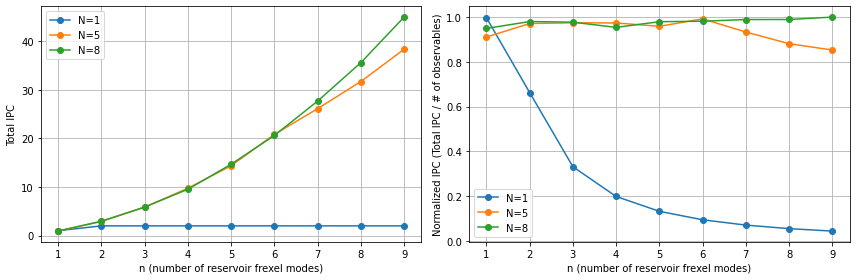

In [3]:
N_vec = [1,5,8]
n_vec = np.array([1,2,3,4,5,6,7,8,9],int)
obs_vec = .5*n_vec*(n_vec+1) # number of observables for each n
obs_vec = obs_vec.astype(int)

fig,ax = plt.subplots(1,2,figsize=(12,4))

for N in N_vec:
    IPC_total = np.load('IPC_total_N%i.npy' %(N))
    ax[0].plot(n_vec,IPC_total,'-o',label='N=%i' %(N))
    ax[1].plot(n_vec,IPC_total/obs_vec,'-o',label='N=%i' %(N))

ax[0].set_xlabel('n (number of reservoir frexel modes)')
ax[0].set_ylabel('Total IPC')
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel('n (number of reservoir frexel modes)')
ax[1].set_ylabel('Normalized IPC (Total IPC / # of observables)')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.savefig('IPC_vs_n.png',dpi=300)
plt.show()